# Pre-trained network (VGG 16)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


 A common and highly effective approach to deep learning on small image datasets is to leverage a pre-trained network. A pre-trained network is simply a saved network previously trained on a large dataset, typically on a large-scale image classification task. If this original dataset is large enough and general enough, then the spatial feature hierarchy learned by the pre-trained network can effectively act as a generic model of our visual world, and hence its features can prove useful for many different computer vision problems, even though these new problems might involve completely different classes from those of the original task. For instance, one might train a network on ImageNet (where classes are mostly animals and everyday objects) and then re-purpose this trained network for something as remote as identifying furniture items in images. Such portability of learned features across different problems is a key advantage of deep learning compared to many older shallow learning approaches, and it makes deep learning very effective for small-data problems.

During this exercise we will use the VGG16 architecture, developed by Karen Simonyan and Andrew Zisserman in 2014, a simple and widely used convnet architecture for ImageNet. Some another pre-trained models are VGG, ResNet, Inception, Inception-ResNet, Xception, DenseNet. Detailed descriptions can be found on this website: Pre-trained network architectures . Please have a look at the VGG architecture.

### Transfer learning

As we saw previously, convnets used for image classification comprise two parts: they start with a series of pooling and convolution layers, and they end with a densely-connected classifier. The first part is called the “convolutional base” of the model. In the case of convnets, “feature extraction” will simply consist of taking the convolutional base of a previously-trained network, running the new data through it, and training a new classifier on top of the output.

 Feature maps of a convnet are presence maps of generic concepts over a picture, which is likely to be useful regardless of the computer vision problem at hand. On the other end, the representations learned by the classifier will necessarily be very specific to the set of classes that the model was trained on – they will only contain information about the presence probability of this or that class in the entire picture. Additionally, representations found in densely-connected layers no longer contain any information about where objects are located in the input image: these layers get rid of the notion of space, whereas the object location is still described by convolutional feature maps. For problems where object location matters, densely-connected features would be largely useless. Note that the level of generality (and therefore reusability) of the representations extracted by specific convolution layers depends on the depth of the layer in the model. Layers that come earlier in the model extract local, highly generic feature maps (such as visual edges, colors, and textures), while layers higher-up extract more abstract concepts (such as “cat ear” or “dog eye”). So if your new dataset differs a lot from the dataset that the original model was trained on, you may be better off using only the first few layers of the model to do feature extraction, rather than using the entire convolutional base.

In our case, since the ImageNet class set did contain multiple dog and cat classes, it is likely that it would be beneficial to reuse the information contained in the densely-connected layers of the original model. However, we will choose not to, in order to cover the more general case where the class set of the new problem does not overlap with the class set of the original model.Let's put this in practice by using the convolutional base of the VGG16 network, trained on ImageNet, to extract interesting features from our cat and dog images, and then training a cat vs. dog classifier on top of these features.

The VGG16 model, among others, comes pre-packaged with Keras. You can import it from the keras.applications module. Here's the list of image classification models (all pre-trained on the ImageNet dataset) that are available as part of keras.applications:

* Xception
* InceptionV3
* ResNet50
* VGG16
* VGG19
* DenseNet
* MobileNet


### VGG-16 model

Import the model from Keras:

In [3]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import keras
from keras import models
from keras import layers
import tensorflow.keras.preprocessing
from tensorflow.keras.preprocessing import  image_dataset_from_directory

In [4]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

58889256/58889256 [==============================] - 4s 0us/step


 We passed three arguments to the constructor:

* weights, to specify which weight checkpoint to initialize the model from
* include_top, which refers to including or not the densely-connected classifier on top of the network. Bydefault, this densely-connected classifier would correspond to the 1000 classes from ImageNet. Since we intendto use our own densely-connected classifier (with only two classes, cat and dog), we don't need to include it.
* input_shape, the shape of the image tensors that we will feed to the network. This argument is purelyoptional: if we don't pass it, then the network will be able to process inputs of any size.


Ex. 1.1 Please analyze the model of VGG-16 (model summary) - after compilation.

In [5]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

Ex. 1.2 What is the final feature map shape ?

 Summary:
 ...

 block4_pool (MaxPooling2D)  (None, 9, 9, 512)         0         
                                                                 
 block5_conv1 (Conv2D)       (None, 9, 9, 512)         2359808   
                                                                 
 block5_conv2 (Conv2D)       (None, 9, 9, 512)         2359808   
                                                                 
 block5_conv3 (Conv2D)       (None, 9, 9, 512)         2359808   
                                                 
 block5_pool (MaxPooling2D)  (None, 4, 4, 512)         0         
                                                                 

 At this point, there are two ways we could proceed to leverage a pre-trained network: feature extraction and fine-tuning:

* Feature Extraction: a new classifier is trained from scratch on top of the pre-trained model.
* Fine-Tuning: unfreezing a few of the top layers of a frozen model base and training both the newly-added    classifier layers and the last layers of the base model.


### Basic feature extraction

Let's start with feature extraction - recording the output of conv_base on our data and using these outputs as inputs to a new model. We will start by simply running instances of the previously-introduced ImageDataGenerator (lab. 3 and 4) to extract images as Numpy arrays as well as their labels. We will extract features from these images simply by calling the predict method of the conv_base model. Import the required module, create the required directory, and preliminarily set up the generator.

In [6]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = '/content/drive/MyDrive/'

train_dir = os.path.join(base_dir, 'data/train')
validation_dir = os.path.join(base_dir, 'data/validation')
test_dir = os.path.join(base_dir, 'data/validation')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

Now we construct a feature extraction function. The size of the first numpy array is: sample size * 4 * 4 * 512, corresponding to the size of the network output, then the label is naturally only a one-dimensional array of sample size. Later, generators are used to package data in batches for easy processing. The generator determines the size of the picture, and then obtains the label of the picture and stores it in the array. The label here is the name of the folder. In this example, there are two folders, so 0 and 1. The processed image is in the form of a data stream, which is equivalent to 20 pictures per batch forming a data stream, and the label is the root.

In [7]:
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

In the later for loop, the processed data stream is input directly into the existing model and output the result. Then the result is stored in the feature array which is defined at the beginning, and the labels are stored in the labels array. In order to avoid infinite loops, a number of restrictions are added to ensure that all data is used without duplication.

Here we create the training set, test set and validation set. Used this method once and keep their labels.

In [8]:
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
1/1 [==============================] - 0s 21ms/step
Found 1000 images belonging to 2 classes.
1/1 [==============================] - 0s 20ms/step
Found 1000 images belonging to 2 classes.
1/1 [==============================] - 0s 32ms/step


The extracted features are currently of shape (samples, 4, 4, 512). We will feed them to a densely-connected classifier.

 Ex. 1.3 Define our densely-connected classifier. First, flatten the features to (samples, 8192). You can do it using reshape function or by adding a Flatten layer before the first Dense layer. Then use two densely-connected layers with the dropout for regularisation. The first layer will have 256 channels and a ReLU activation function. Dropout set to 0.5. The classification layer has a Sigmoid activation function.

The model summary should look like this:

In [ ]:
"""
Layer (type)                 Output Shape              Param #
=================================================================
dense_55 (Dense)             (None, 256)               2097408
_________________________________________________________________
dropout (Dropout)            (None, 256)               0
_________________________________________________________________
dense_56 (Dense)             (None, 1)                 257
=================================================================
Total params: 2,097,665
Trainable params: 2,097,665
Non-trainable params: 0
"""

'\nLayer (type)                 Output Shape              Param #   \n=================================================================\ndense_55 (Dense)             (None, 256)               2097408   \n_________________________________________________________________\ndropout (Dropout)            (None, 256)               0         \n_________________________________________________________________\ndense_56 (Dense)             (None, 1)                 257       \n=================================================================\nTotal params: 2,097,665\nTrainable params: 2,097,665\nNon-trainable params: 0\n'

In [9]:
from keras import models
from keras import layers

image_height, image_width, image_channels = 150, 150, 3

model = models.Sequential()
model.add(layers.Flatten(input_shape=(4, 4, 512)))
model.add(layers.Dense(256, activation='relu')) # number_of_channels last conv2d
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

# ELSE ======================================================================================
# model.add(data_augmentation)
# model.add(layers.Rescaling(1/255, input_shape=(image_height, image_width, image_channels)))
# model.add(layers.Conv2D(
#     number_of_channels[0],
#     (filterSizeConv2D[0],
#      filterSizeConv2D[1]),
#      activation='relu',
#      input_shape=(image_height, image_width, image_channels)))
# model.add(layers.MaxPooling2D((filterSizePooling2D[0], filterSizePooling2D[1])))
# filterSizeConv2D = 3, 3
# filterSizePooling2D = 2, 2
# number_of_channels = 32, 64, 128, 128, 512

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 2097665 (8.00 MB)
Trainable params: 2097665 (8.00 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Ex. 1.4 Train the model using the following parameters:<br>
RMSprop(lr=2e-5) optimizer,<br>
Binary crossentropy loss function,<br>
Accuracy metric.<br>


In [11]:
optimizerRMSprop = keras.optimizers.RMSprop(learning_rate=2e-5)
model.compile(optimizer=optimizerRMSprop,
                loss='binary_crossentropy',
                metrics=['accuracy'])

Ex. 1.5 Fit the model with 30 epochs, batch size 20, and validation data. Training is very fast since we only have to deal with two Dense layers.

Expected outcome:

In [12]:
history = model.fit(
      train_features,
      train_labels,
      steps_per_epoch=100,
      epochs=30,
      validation_data=(validation_features, validation_labels),
      validation_steps=50,
      batch_size=20)

Epoch 1/30
100/100 [==============================] - 3s 6ms/step - loss: 0.6037 - accuracy: 0.6590 - val_loss: 0.4418 - val_accuracy: 0.8470
Epoch 2/30
100/100 [==============================] - 0s 4ms/step - loss: 0.4310 - accuracy: 0.8115 - val_loss: 0.3691 - val_accuracy: 0.8480
Epoch 3/30
100/100 [==============================] - 0s 4ms/step - loss: 0.3614 - accuracy: 0.8450 - val_loss: 0.3259 - val_accuracy: 0.8750
Epoch 4/30
100/100 [==============================] - 0s 4ms/step - loss: 0.3139 - accuracy: 0.8735 - val_loss: 0.3035 - val_accuracy: 0.8810
Epoch 5/30
100/100 [==============================] - 0s 4ms/step - loss: 0.3002 - accuracy: 0.8700 - val_loss: 0.2893 - val_accuracy: 0.8840
Epoch 6/30
100/100 [==============================] - 0s 4ms/step - loss: 0.2675 - accuracy: 0.8985 - val_loss: 0.2789 - val_accuracy: 0.8870
Epoch 7/30
100/100 [==============================] - 0s 4ms/step - loss: 0.2500 - accuracy: 0.9030 - val_loss: 0.2812 - val_accuracy: 0.8830
Epoch 

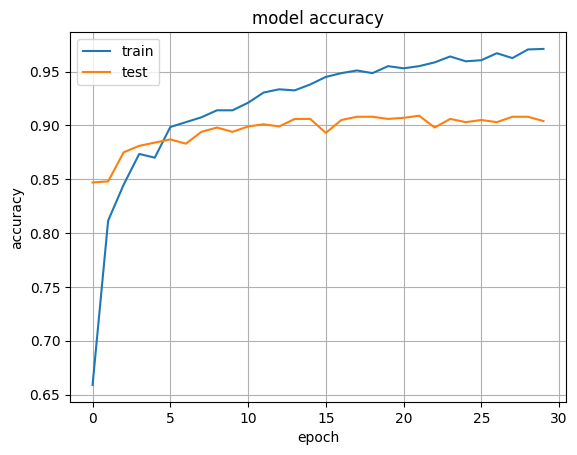

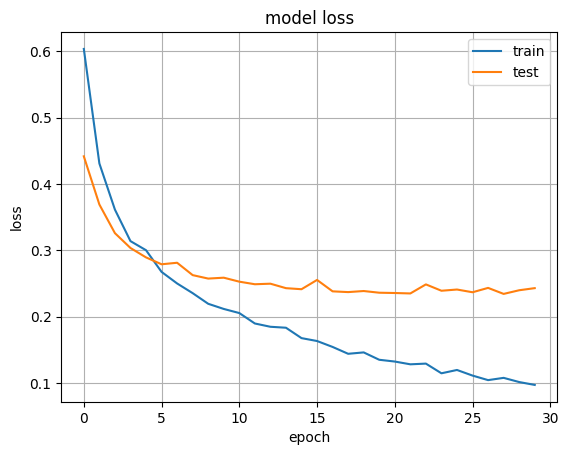

In [13]:
history_dict = history.history
history_dict.keys()

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.grid()
plt.show()

Ex. 1.6 Plot the loss and accuracy curves during training.

We reach a validation accuracy of about 90%, much better than what we could achieve in the previous section with our small model trained from scratch. However, the overfitting problem is still there…

## Pre-trained part as an extended layer

The second technique is much slower and more expensive, but allows us to leverage data augmentation during training: extending the conv_base model and running it end-to-end on the inputs. Note that this technique is in fact so expensive that you should only attempt it if you have access to a GPU: it is absolutely intractable on CPU. If you cannot run your code on GPU, then the previous technique is the way to go.

Because models behave just like layers, you can add a model (like our conv_base) to a Sequential model just like you would add a layer. So you can do the following:

In [14]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               2097408   
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16812353 (64.13 MB)
Trainable params: 16812353 (64.13 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Ex. 2.1 Please analyse the model summary. How many parameters do you have now ? How many parameters are trainable?
Before we compile and train our model, a very important thing to do is to freeze the convolutional base. “Freezing” a layer or set of layers means preventing their weights from getting updated during training. If we don't do this, then the representations that were previously learned by the convolutional base would get modified during training. Since the Dense layers on top are randomly initialized, very large weight updates would be propagated through the network, effectively destroying the representations previously learned.

In Keras, freezing a network is done by setting its trainable attribute to False:

In [16]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30


This is the number of trainable weights before freezing the conv base: 30

In [17]:
conv_base.trainable = False

print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


With this setup, only the weights from the two Dense layers that we added will be trained. That's a total of four weight tensors: two per layer (the main weight matrix and the bias vector). Note that in order for these changes to take effect, we must first compile the model. If you ever modify weight trainability after compilation, you should then re-compile the model, or these changes would be ignored.

Ex. 2.2 Implement and fit the model like in the previous labs (with data augmentation). If the process takes too much time, please instead read saved model from the following repository:Model. Check the summary.

In [18]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [19]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

<ipython-input-19-8c1a8a6f98a4>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/30
100/100 - 30s - loss: 0.8381 - acc: 0.6725 - val_loss: 0.3738 - val_acc: 0.8220 - 30s/epoch - 296ms/step
Epoch 2/30
100/100 - 22s - loss: 0.4384 - acc: 0.7880 - val_loss: 0.3479 - val_acc: 0.8420 - 22s/epoch - 216ms/step
Epoch 3/30
100/100 - 21s - loss: 0.4094 - acc: 0.8120 - val_loss: 0.2644 - val_acc: 0.8900 - 21s/epoch - 213ms/step
Epoch 4/30
100/100 - 23s - loss: 0.3863 - acc: 0.8280 - val_loss: 0.3118 - val_acc: 0.8620 - 23s/epoch - 230ms/step
Epoch 5/30
100/100 - 23s - loss: 0.3553 - acc: 0.8455 - val_loss: 0.2609 - val_acc: 0.8880 - 23s/epoch - 233ms/step
Epoch 6/30
100/100 - 21s - loss: 0.3663 - acc: 0.8300 - val_loss: 0.2674 - val_acc: 0.8860 - 21s/epoch - 213ms/step
Epoch 7/30
100/100 - 23s - loss: 0.3162 - acc: 0.8575 - val_loss: 0.2730 - val_acc: 0.8940 - 23s/epoch - 233ms/step
Epoch 8/30
100/100 - 22s - loss: 0.3477 - acc: 0.8475 - val_loss: 0.2541 - val_acc: 0.8980 - 22s/epoch - 216ms/step
Epoch 9/30
100/100 - 23s - loss: 0.3369 - acc: 0.8545 - val_loss: 0.2464

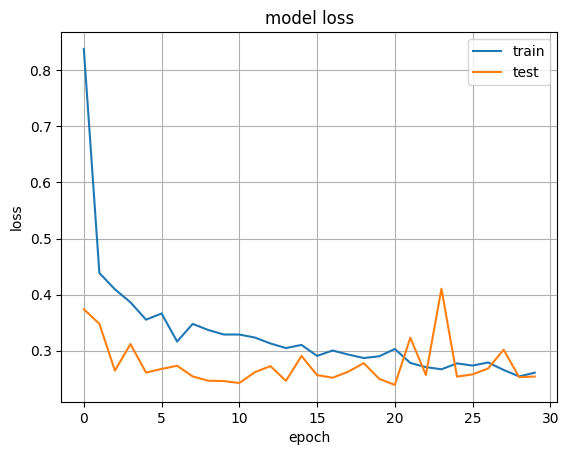

In [23]:
history_dict = history.history
history_dict.keys()

# summarize history for accuracy
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.grid()
# plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.grid()
plt.show()

## Fine-tuning

Another widely used technique for model reuse, complementary to feature extraction, is fine-tuning. Fine-tuning consists of unfreezing a few of the top layers of a frozen model base used for feature extraction, and jointly training both the newly added part of the model (in our case, the fully-connected classifier) and these top layers. This is called “fine-tuning” because it slightly adjusts the more abstract representations of the model being reused, in order to make them more relevant for the problem at hand.

Please have a look at the VGG-16 architecture |VGG-16

We have stated before that it was necessary to freeze the convolution base of VGG16 in order to be able to train a randomly initialized classifier on top. For the same reason, it is only possible to fine-tune the top layers of the convolutional base once the classifier on top has already been trained. If the classified wasn't already trained, then the error signal propagating through the network during training would be too large, and the representations previously learned by the layers being fine-tuned would be destroyed. Thus the steps for fine-tuning a network are as follow:
1) Add your custom network on top of an already trained base network.
2) Freeze the base network.
3) Train the part you added.
4) Unfreeze some layers in the base network.
5) Jointly train both these layers and the part you added.

We have already completed the first 3 steps when doing feature extraction. Let's proceed with the 4th step: we will unfreeze our conv_base, and then freeze individual layers inside of it.

In [24]:
from keras import models
from keras import layers

# model = models.Sequential()
# model.add(layers.Flatten(input_shape=(4, 4, 512)))
# model.add(layers.Dense(256, activation='relu')) # number_of_channels last conv2d
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(1, activation='sigmoid'))

# -----------------------------------------------------------------
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))


In [25]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dense_4 (Dense)             (None, 256)               2097408   
                                                                 
 dense_5 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16812353 (64.13 MB)
Trainable params: 2097665 (8.00 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [26]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 4


In [27]:
conv_base.trainable = False

print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


In [28]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [29]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

# history = model.fit(
#       train_features,
#       train_labels,
#       steps_per_epoch=100,
#       epochs=30,
#       validation_data=(validation_features, validation_labels),
#       validation_steps=50,
#       batch_size=20)

<ipython-input-29-5ad7162e971f>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/30
100/100 - 25s - loss: 0.6433 - acc: 0.6915 - val_loss: 0.3962 - val_acc: 0.8190 - 25s/epoch - 249ms/step
Epoch 2/30
100/100 - 21s - loss: 0.4370 - acc: 0.7925 - val_loss: 0.2990 - val_acc: 0.8780 - 21s/epoch - 212ms/step
Epoch 3/30
100/100 - 22s - loss: 0.4168 - acc: 0.8045 - val_loss: 0.2892 - val_acc: 0.8780 - 22s/epoch - 222ms/step
Epoch 4/30
100/100 - 21s - loss: 0.3757 - acc: 0.8285 - val_loss: 0.2591 - val_acc: 0.8920 - 21s/epoch - 211ms/step
Epoch 5/30
100/100 - 24s - loss: 0.3847 - acc: 0.8250 - val_loss: 0.2784 - val_acc: 0.8840 - 24s/epoch - 236ms/step
Epoch 6/30
100/100 - 21s - loss: 0.3622 - acc: 0.8365 - val_loss: 0.2714 - val_acc: 0.8830 - 21s/epoch - 215ms/step
Epoch 7/30
100/100 - 21s - loss: 0.3450 - acc: 0.8460 - val_loss: 0.2660 - val_acc: 0.8870 - 21s/epoch - 211ms/step
Epoch 8/30
100/100 - 21s - loss: 0.3348 - acc: 0.8515 - val_loss: 0.2481 - val_acc: 0.8950 - 21s/epoch - 214ms/step
Epoch 9/30
100/100 - 24s - loss: 0.3313 - acc: 0.8520 - val_loss: 0.2529

Ex. 3.1 Analyse the conv_base.summary().

We will fine-tune the last 3 convolutional layers, which means that all layers up until block4_pool should be frozen, and the layers block5_conv1, block5_conv2 and block5_conv3 should be trainable. Why not fine-tune more layers? Why not fine-tune the entire convolutional base? We could. However, we need to consider that:

* Earlier layers in the convolutional base encode more generic, reusable features, while layers higher up encode more specialized features. It is more useful to fine-tune the more specializedfeatures, as these are the ones that need to be repurposed on our new problem. There would be fast-decreasing returns in fine-tuning lower layers.
* The more parameters we are training, the more we are at risk of overfitting. The convolutional base has 15M parameters, so it would be risky to attempt to train it on our small dataset.


Thus, in our situation, it is a good strategy to only fine-tune the top 2 to 3 layers in the convolutional base.

Let's set this up, starting from where we left off in the previous example:

In [30]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

Now we can start fine-tuning our network. We will do this with the RMSprop optimizer, using a very low learning rate. The reason for using a low learning rate is that we want to limit the magnitude of the modifications we make to the representations of the 3 layers that we are fine-tuning. Updates that are too large may harm these representations.

Now let's proceed with fine-tuning (like before read the model weights from model h5):

In [31]:
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

<ipython-input-31-0ef542032131>:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/100
100/100 [==============================] - 28s 225ms/step - loss: 27.9430 - acc: 0.5080 - val_loss: 0.6944 - val_acc: 0.5150
Epoch 2/100
100/100 [==============================] - 23s 226ms/step - loss: 0.8124 - acc: 0.6085 - val_loss: 0.3796 - val_acc: 0.8340
Epoch 3/100
100/100 [==============================] - 23s 232ms/step - loss: 0.5392 - acc: 0.7620 - val_loss: 0.3132 - val_acc: 0.8850
Epoch 4/100
100/100 [==============================] - 25s 255ms/step - loss: 0.4961 - acc: 0.8250 - val_loss: 0.2477 - val_acc: 0.8980
Epoch 5/100
100/100 [==============================] - 23s 231ms/step - loss: 0.3714 - acc: 0.8465 - val_loss: 0.2338 - val_acc: 0.9050
Epoch 6/100
100/100 [==============================] - 23s 233ms/step - loss: 0.3469 - acc: 0.8665 - val_loss: 0.2448 - val_acc: 0.9060
Epoch 7/100
100/100 [==============================] - 22s 224ms/step - loss: 0.3358 - acc: 0.8830 - val_loss: 0.1944 - val_acc: 0.9180
Epoch 8/100
100/100 [==========================

In [40]:
history_dict = history.history
acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = np.arange(1, len(acc) + 1)

Ex. 3.2 Plot your results using the same plotting code as before. Smooth the curves/plots using following code:

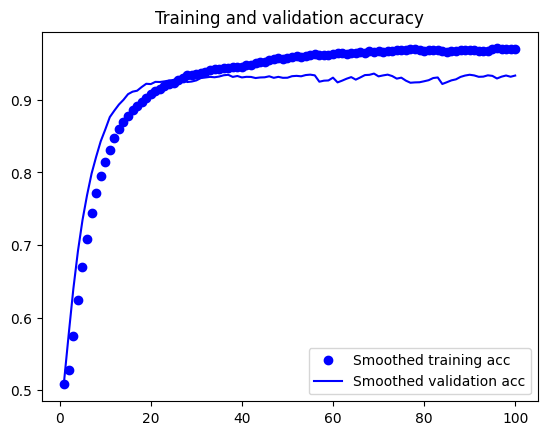

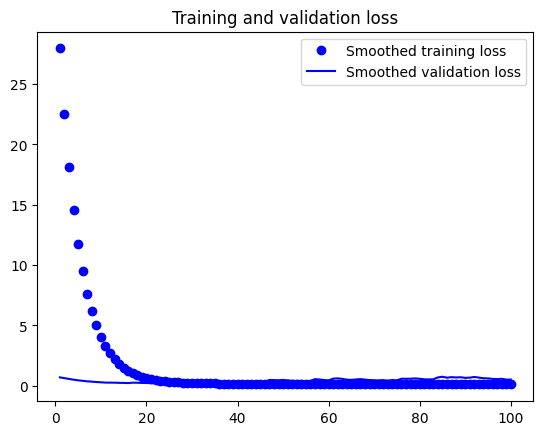

In [41]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Ex. 3.3 Evaluate this model on the test data:

In [42]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.


<ipython-input-42-5f9a0322f4f1>:7: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)


test acc: 0.9399999976158142


test acc: 0.96799999237

Here we got a test accuracy of 97%. In the original Kaggle competition around this dataset, this would have been one of the top results. However, using modern deep learning techniques, we managed to reach this result using only a very small fraction of the training data available (about 10%). There is a huge difference between being able to train on 20,000 samples compared to 2,000 samples!